In [ ]:
import requests, csv, os, datetime, pprint, json, kintone, time, sys,subprocess, calendar
from geopy.geocoders import Nominatim
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from typing import Optional, Dict, Any

ModuleNotFoundError: No module named 'kintone'

In [ ]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
year = 2023
geolocator = Nominatim(user_agent="spaceapps24")
features = ["PRECTOTCORR", "T2M_MAX"]
cityState = "Seattle, WA"
cityStateFileName = "seattleWA"
outputFileName = "features.csv"
params = ",".join(features)
datax = []
datay = []
yearsPastTen = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
yearsPastThirty = [1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
                   1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
                   2013]
monthDatesAverage = 0
dataxTenPrivate = []
datayTenPrivate = []
dataxTen = []
datayTen = []
dataxThirtyPrivate = []
datayThirtyPrivate = []
dataxThirty = []
datayThirty = []
dataxAverage = 0
datayAverage = 0
monthsName = ["Jan", "Feb", "Mar", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

In [ ]:
# Takes "cityName, stateCode" as cityState and returns its (lat, lon).
def cityStateToLatLon(cityState):
    queryParams = {"city" : cityState.split(",")[0].lstrip().rstrip(),
                   "state" : cityState.split(",")[1].lstrip().rstrip(),
                   "country" : "United States" }
    location = geolocator.geocode(query=queryParams, timeout=1000)
    if location != None:
        return (location.latitude, location.longitude)
    else:
        return (None, None)

In [ ]:
# Downloads data from NASA POWER for cityState (i.e. "cityName, stateCode").
# Generates a CSV file for the cityState (e.g. Boston-MA.csv).
def downloadDataForCity(cityState, startDate, endDate, params):
    lat, lon = cityStateToLatLon(cityState)
    city = cityState.split(",")[0].lstrip().rstrip()
    state = cityState.split(",")[1].lstrip().rstrip()
    url = "https://power.larc.nasa.gov/api/temporal/daily/point?parameters=" + \
            str(params) + "&community=AG&" + \
            "longitude=" + str(lon) + "&latitude=" + str(lat) + \
            "&start=" + str(startDate) + "&end=" + str(endDate) + "&format=CSV"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to download data from NASA POWER.",
              response.status_code, (lat,lon))
        return (None, lat, lon)
    elif response.status_code == 200:
        print("Downloaded data from NASA POWER for", cityState, (lat,lon))
        downloadedFile = city + "-" + state + ".csv"
        with open(downloadedFile, "wb") as f:
            f.write(response.content)
            print(response.content)
        return (downloadedFile, lat, lon)

In [ ]:
# Return the last day of month as YYYYMMDD
def returnLastDayOfMonth(year, month):
    lastDay = calendar.monthrange(year, month)
    return str(year) + str(month).zfill(2) + str(lastDay[1])

In [ ]:
# Removes the header section from csvFileName (a CSV file downloaded from NASA POWER).
# Saves remaining data in a new CSV file (e.g. Boston-MA-cleaned.csv)
def cleanCsvFile(csvFileName):
    rows =[]
    with open(csvFileName, "r") as f:
        csvReader = csv.reader(f)
        # Remove the header lines
        for row in csvReader:
            if row[0] == "-END HEADER-":
                break
        # Copy each remaining row to a new CSV file
        for row in csvReader:
            rows.append(row)
        outputFileName = csvFileName[:-4] + "-" + "cleaned.csv"
        with open(outputFileName, 'w') as f:
            writer = csv.writer(f)
            writer.writerows(rows)
    return outputFileName

In [ ]:
# Takes a "cleaned" CSV file and calculates the mean of each feature.
# Returns a list of mean feature values.
def getMeanFeatureValues(csvFileName, features):
    featureSum = [0] * len(features)
    featureMissingCount = [0] * len(features)
    meanFeatures = []

    with open(csvFileName, "r") as f:
        csvReader = csv.reader(f)
        firstLine = next(csvReader)
        if firstLine[2:] != features:
            print("The expected features are not included in an input file.")
            return None
        else:
            for rowindex, row in enumerate(csvReader):
                for i, feature in enumerate(features):
                    if float( row[2+i] ) != -999:
                        featureSum[i] += float(row[2+i])
                    else:
                        featureMissingCount[i] += featureMissingCount[i]
            for i, feature in enumerate(features):
                meanFeatures.append(
                    featureSum[i]/(rowindex+1-featureMissingCount[i]) )
            return meanFeatures

In [ ]:
#Returns a string of current time.
def getCurrentTimeStamp() -> str:
    dt = datetime.datetime.now()
    return "{:d}-{:02d}-{:02d}-{:02d}-{:02d}-{:02d}".format(
        dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)

In [ ]:
#Downloads 10 years of data from NASA POWER (2014 - 2023)
for month in months:
  for year in yearsPastTen:
    startDate = str(year) + str(month).zfill(2) + '01'
    endDate = int(returnLastDayOfMonth(year, month))
    csvFileName, lat, lon = downloadDataForCity(cityState, int(startDate), int(endDate), params)
    cleanedCsvFileName = cleanCsvFile(csvFileName)
    featureValues = getMeanFeatureValues(cleanedCsvFileName, features)
    print(featureValues)
    dataxTenPrivate.append(featureValues[0])
    datayTenPrivate.append(featureValues[1])

  for data in range(len(dataxTenPrivate)):
    dataxAverage += dataxTenPrivate[data]
  dataxAverage = dataxAverage / 10

  for data in range(len(datayTenPrivate)):
    datayAverage += datayTenPrivate[data]
  datayAverage = datayAverage / 10

  for year in yearsPastTen:
    monthDatesAverage += calendar.monthrange(year, month)[1]
  monthDatesAverage = monthDatesAverage / 10

  dataxTen.append(dataxAverage * monthDatesAverage)
  datayTen.append(datayAverage)

  dataxAverage = 0
  datayAverage = 0
  monthDatesAverage = 0

  dataxTenPrivate.clear()
  datayTenPrivate.clear()

Downloaded data from NASA POWER for Sacramento, CA (38.5810606, -121.493895)
b'-BEGIN HEADER-\r\nNASA/POWER CERES/MERRA2 Native Resolution Daily Data \r\nDates (month/day/year): 01/01/2014 through 01/31/2014 \r\nLocation: Latitude  38.5811   Longitude -121.4939 \r\nElevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 128.08 meters\r\nThe value for missing source data that cannot be computed or is outside of the sources availability range: -999 \r\nParameter(s): \r\nPRECTOTCORR     MERRA-2 Precipitation Corrected (mm/day) \r\nT2M_MAX         MERRA-2 Temperature at 2 Meters Maximum (C) \r\n-END HEADER-\r\nYEAR,DOY,PRECTOTCORR,T2M_MAX\n2014,1,0.0,16.15\n2014,2,0.0,18.78\n2014,3,0.0,18.48\n2014,4,0.0,21.1\n2014,5,0.0,20.97\n2014,6,0.0,17.33\n2014,7,0.0,17.85\n2014,8,0.0,12.37\n2014,9,0.0,16.69\n2014,10,0.0,17.05\n2014,11,0.5,12.73\n2014,12,0.08,16.09\n2014,13,0.0,18.33\n2014,14,0.0,20.47\n2014,15,0.0,22.26\n2014,16,0.0,22.62\n2014,17,0.0,23.62\n2014,18,0.0,21.44\n2014,19

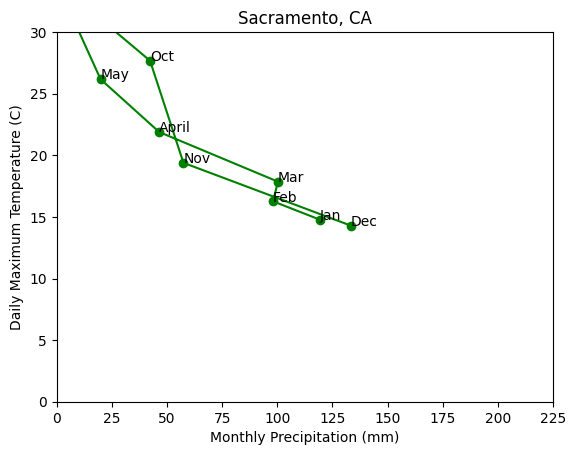

In [ ]:
#Creates a hythergraph using 10 years of data.
plt.title(cityState)
plt.xlabel("Monthly Precipitation (mm)")
plt.ylabel("Daily Maximum Temperature (C)")
plt.xlim(0, 250)
plt.ylim(0, 45)
plt.plot(dataxTen, datayTen, linestyle='-', marker='o', color='g')

for i, txt in enumerate(monthsName):
  plt.annotate(txt, (dataxTen[i], datayTen[i]))

plt.show()

In [ ]:
#Downloads 30 years of data from NASA POWER (1983 - 2013)
for month in months:
  for year in yearsPastThirty:
    startDate = str(year) + str(month).zfill(2) + '01'
    endDate = int(returnLastDayOfMonth(year, month))
    csvFileName, lat, lon = downloadDataForCity(cityState, int(startDate), int(endDate), params)
    cleanedCsvFileName = cleanCsvFile(csvFileName)
    featureValues = getMeanFeatureValues(cleanedCsvFileName, features)
    print(featureValues)
    dataxThirtyPrivate.append(featureValues[0])
    datayThirtyPrivate.append(featureValues[1])

  for data in range(len(dataxThirtyPrivate)):
    dataxAverage += dataxThirtyPrivate[data]
  dataxAverage = dataxAverage / 31

  for data in range(len(datayThirtyPrivate)):
    datayAverage += datayThirtyPrivate[data]
  datayAverage = datayAverage / 31

  for year in yearsPastThirty:
    monthDatesAverage += calendar.monthrange(year, month)[1]
  monthDatesAverage = monthDatesAverage / 31

  dataxThirty.append(dataxAverage * monthDatesAverage)
  datayThirty.append(datayAverage)

  dataxAverage = 0
  datayAverage = 0
  monthDatesAverage = 0

  dataxThirtyPrivate.clear()
  datayThirtyPrivate.clear()

Downloaded data from NASA POWER for Sacramento, CA (38.5810606, -121.493895)
b'-BEGIN HEADER-\r\nNASA/POWER CERES/MERRA2 Native Resolution Daily Data \r\nDates (month/day/year): 01/01/1983 through 01/31/1983 \r\nLocation: Latitude  38.5811   Longitude -121.4939 \r\nElevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 128.08 meters\r\nThe value for missing source data that cannot be computed or is outside of the sources availability range: -999 \r\nParameter(s): \r\nPRECTOTCORR     MERRA-2 Precipitation Corrected (mm/day) \r\nT2M_MAX         MERRA-2 Temperature at 2 Meters Maximum (C) \r\n-END HEADER-\r\nYEAR,DOY,PRECTOTCORR,T2M_MAX\n1983,1,0.0,11.93\n1983,2,0.04,9.07\n1983,3,0.0,14.17\n1983,4,0.04,16.09\n1983,5,0.0,15.42\n1983,6,0.01,15.3\n1983,7,0.0,16.29\n1983,8,0.0,16.1\n1983,9,0.01,14.69\n1983,10,0.0,18.96\n1983,11,0.0,19.86\n1983,12,0.01,19.25\n1983,13,0.04,19.48\n1983,14,0.08,15.98\n1983,15,2.68,19.85\n1983,16,5.37,12.4\n1983,17,6.37,14.39\n1983,18,17.28,12.88\

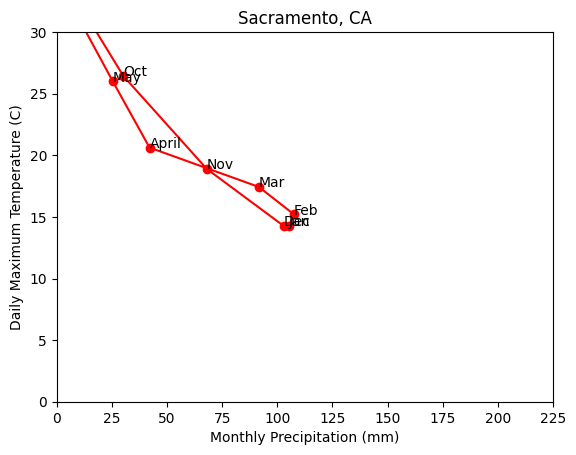

In [ ]:
#Creates a hythergraph using 30 years of data.
plt.title(cityState)
plt.xlabel("Monthly Precipitation (mm)")
plt.ylabel("Daily Maximum Temperature (C)")
plt.xlim(0, 250)
plt.ylim(0, 45)
plt.plot(dataxThirty, datayThirty, linestyle='-', marker='o', color='r')

for i, txt in enumerate(monthsName):
  plt.annotate(txt, (dataxThirty[i], datayThirty[i]))

plt.show()

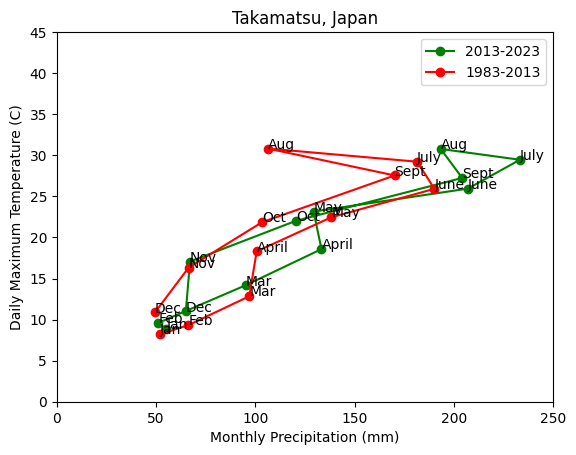

In [ ]:
#Combines hythergraphs (10 years and 30 years) into one hythergraph.
plt.title(cityState)
plt.xlabel("Monthly Precipitation (mm)")
plt.ylabel("Daily Maximum Temperature (C)")
plt.xlim(0, 250)
plt.ylim(0, 45)

plt.plot(dataxTen, datayTen, label = "2013-2023", linestyle='-', marker='o', color='g')
for i, txt in enumerate(monthsName):
  plt.annotate(txt, (dataxTen[i], datayTen[i]))

plt.plot(dataxThirty, datayThirty, label = "1983-2013", linestyle='-', marker='o', color='r')
for i, txt in enumerate(monthsName):
  plt.annotate(txt, (dataxThirty[i], datayThirty[i]))

timeStamp = getCurrentTimeStamp()
picFile = cityStateFileName + timeStamp + ".jpg"
plt.savefig(cityStateFileName + timeStamp + ".jpg")

plt.legend()
plt.show()

In [ ]:
#Uploads the hythergraph to Kintone.
sdomain = "sdomain"
appId = "appIDd"
token = "token"

fileKey = kintone.uploadFile(subDomain=sdomain,
                              apiToken=token,
                              filePath=picFile)
if fileKey is None:
  sys.exit()

payload = {"app": appId,
          "record": {"hythergraph": {"value": [{"fileKey": fileKey}] },
          "city": {"value": cityState} }}

recordId = kintone.uploadRecord(subDomain=sdomain,
                                apiToken=token,
                                record=payload)

if recordId is None:
  sys.exit()

File uploaded. File key: 9c7da3ce-5091-45ef-9dea-655cf8f0ff34
Record uploaded. Record ID: 7
